<a href="https://colab.research.google.com/github/alvinkimbowa/low-field-mri/blob/main/Code/Noise_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Obtain the image data from drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!ln -s '/content/drive/My Drive/Low Field MRI' /mydrive

Mounted at /content/drive


In [ ]:
import os

# Low-Field MRI Data
print("Copying low field MRI data (axial 60 dataset)...")
dst = 'axial_10days_images'
if os.path.exists(dst):
    !rm -r "{dst}"
!cp -r "/mydrive/Datasets/SG Data/{dst}.zip" "/content"
!unzip -o -q 'axial_10days_images.zip' -d '/content'
print("Done!")

Copying low field MRI data (axial 60 dataset)...
Done!


# Import necessary libraries

In [ ]:
import tqdm
import glob
import scipy
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

# Find the average rician parameters for all images


In [ ]:
def read_image(filename):
    img = np.load(filename)
    return img

def fit_rician(image, corner_shape=(25,25)):
    '''
        This function returns the average rician parameters basing
        on four patches
    '''
    bs = []
    locs = []
    scales = []
    for i in range(4):
        if i == 0:
            patch = image[:corner_shape[0], :corner_shape[1]]
        if i == 1:
            patch = image[-corner_shape[0]:, :corner_shape[1]]
        if i == 2:
            patch = image[:corner_shape[0], -corner_shape[1]:]
        if i == 3:
            patch = image[-corner_shape[0]:, -corner_shape[1]:]
        
        b, loc, scale = scipy.stats.rice.fit(patch.ravel())
        
        bs.append(b)
        locs.append(loc)
        scales.append(scale)
    
    b_ave = sum(bs)/len(bs)
    loc_ave = sum(locs)/len(locs)
    scale_ave = sum(scales)/len(scales)

    return (b_ave, loc_ave, scale_ave)

def visualize_fit(patch, b, loc, scale):
    x = np.linspace(np.min(patch), np.max(patch))
    plt.hist(patch.ravel(), bins=256, density=True)
    plt.plot(x, scipy.stats.rice.pdf(x, b, loc=loc, scale=scale),)
    plt.title("Rician Distribution")
    plt.show()
    return

def simulate_image_noise(filename, plot=False):
    '''
        This function fits a rician curve on a single image
    '''
    img = read_image(filename)
    b, loc, scale = fit_rician(img)
    if plot:
        visualize_fit(img[:25,:25], b, loc, scale)
    return (b,loc,scale)

def simulate_noise(folder):
    '''
        This function returns the average rician parameters based
        on all the images in the folder
    '''
    bs = []
    locs = []
    scales = []

    for fn in tqdm(glob.glob(folder)):
        # print(fn)
        b, loc, scale = simulate_image_noise(fn)
        
        bs.append(b)
        locs.append(loc)
        scales.append(scale)

    b_ave = sum(bs)/len(bs)
    loc_ave = sum(locs)/len(locs)
    scale_ave = sum(scales)/len(scales)

    return (b_ave,loc_ave,scale_ave)

In [ ]:
image_folder = '/content/axial_10days_images/*/*/*'
b,loc,scale = simulate_noise(image_folder)

print("b: ", b)
print("loc: ", loc)
print("scale: ", scale)

  0%|          | 0/750 [00:00<?, ?it/s]

b:  0.0019343329876713243
loc:  -2.212777183185709
scale:  55.677812882122936


## Visualize the average parameters on a single image patch.

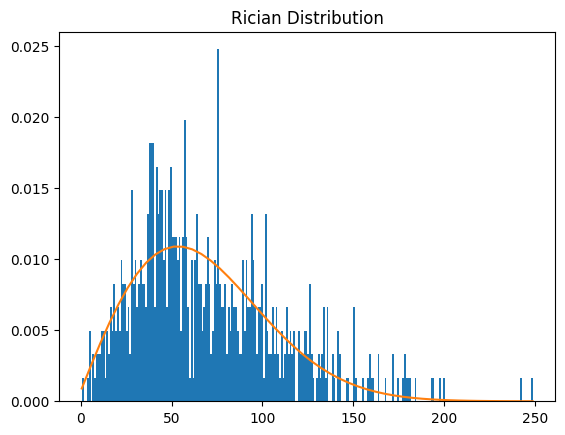

In [ ]:
fn = '/content/axial_10days_images/Day10_01142023/Session1_11AM/15.npy'
img = read_image(fn)
visualize_fit(img[:25,:25], b, loc, scale)

# Obtain 30 average

In [ ]:
def get_numeric_count(filename):
    return int(filename.split('.')[0])

def average_images(image_folder):
    '''
        This function finds the 30X average
    '''
    
    average_30 = np.zeros(shape=(25,155,155))

    for session in tqdm(glob.glob(image_folder)):
        img_names = sorted(os.listdir(session), key=get_numeric_count)
        img_names = list(map(lambda x: os.path.join(session, x), img_names))
        for i,img_name in enumerate(img_names):
            average_30[i] += read_image(img_name)
    
    average_30 /= 30
    return average_30

In [ ]:
image_folder = '/content/axial_10days_images/*/*'
average_30 = average_images(image_folder)
average_30.shape

  0%|          | 0/30 [00:00<?, ?it/s]

(25, 155, 155)

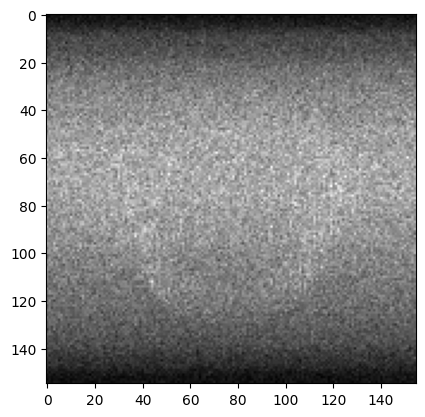

In [ ]:
plt.imshow(average_30[0], cmap='gray')

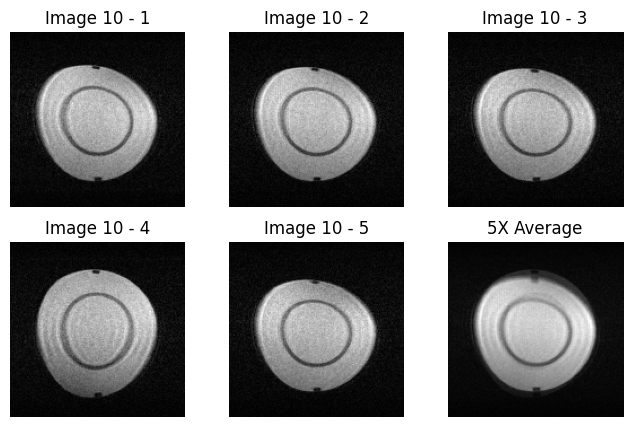

In [ ]:
img1 = read_image("/content/axial_10days_images/Day10_01142023/Session1_11AM/10.npy")
img2 = read_image("/content/axial_10days_images/Day10_01142023/Session2_2PM/10.npy")
img3 = read_image("/content/axial_10days_images/Day10_01142023/Session3_5PM/10.npy")
img4 = read_image("/content/axial_10days_images/Day1_01032023/Session1_11AM/10.npy")
img5 = read_image("/content/axial_10days_images/Day1_01032023/Session2_2PM/10.npy")
ave_img = (img1 + img2 + img3 + img4 + img5)/5

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(2,3,1)
ax.imshow(img1, cmap='gray')
ax.set_title("Image 10 - 1")
ax.axis("off")

ax = fig.add_subplot(2,3,2)
ax.imshow(img2, cmap='gray')
ax.set_title("Image 10 - 2")
ax.axis("off")

ax = fig.add_subplot(2,3,3)
ax.imshow(img3, cmap='gray')
ax.set_title("Image 10 - 3")
ax.axis("off")

ax = fig.add_subplot(2,3,4)
ax.imshow(img4, cmap='gray')
ax.set_title("Image 10 - 4")
ax.axis("off")

ax = fig.add_subplot(2,3,5)
ax.imshow(img5, cmap='gray')
ax.set_title("Image 10 - 5")
ax.axis("off")

ax = fig.add_subplot(2,3,6)
ax.set_title("5X Average")
ax.imshow(ave_img, cmap='gray')
ax.axis("off")

plt.show()

In [ ]:
x = np.linspace(155,155)  
noise = scipy.stats.rice.rvs(
    b=b, loc=loc, scale=scale, size=(155,155)
    )

noise = noise.reshape(155,155)
noise.shape

(155, 155)

In [ ]:
img1.max(), img1.min()

(2465.4440561733754, 0.37458392055936995)

In [ ]:
noise.max(), noise.min()

(261.4985610096445, -1.7975664426489961)

In [ ]:
img1.shape, noise.shape

((155, 155), (155, 155))

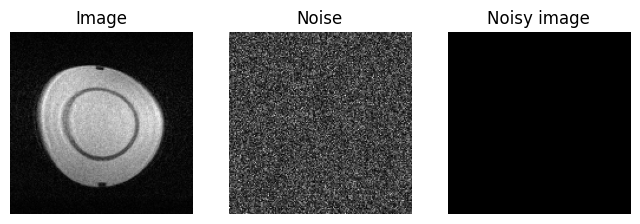

In [ ]:
noisy_img = img1 - img1

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,3,1)
ax.imshow(img1, cmap='gray')
ax.set_title("Image")
ax.axis('off')

ax = fig.add_subplot(1,3,2)
ax.imshow(noise, cmap='gray')
ax.set_title("Noise")
ax.axis('off')

ax = fig.add_subplot(1,3,3)
ax.imshow(noisy_img, cmap='gray')
ax.set_title("Noisy image")
ax.axis('off')
plt.show()